finished getting raw counts
closest match by euclidean distance: pretty
meningitis - i = pretty - vaccine

closest match by cosine distance: about
meningitis - i = about - vaccine

closest match by euclidean distance: me
meningitis - canadian = me - vaccine

closest match by cosine distance: yes
meningitis - canadian = yes - vaccine



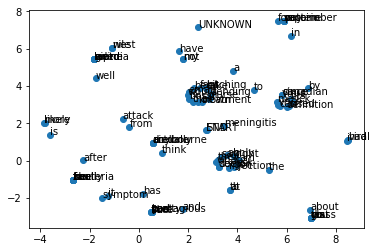

In [2]:
import json
from time import sleep
from flask import Flask
from cleaner import *
from kafka import KafkaConsumer
from util import *
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, PCA, KernelPCA
from sklearn.feature_extraction.text import TfidfTransformer


def main(text):
    
    analogies_to_try = (
        ('meningitis', 'i', 'vaccine'),
        ('meningitis', 'canadian', 'vaccine')
      
  )

    sentences, word2idx = get_data(text.strip(),n_vocab=100)

    notfound = False
    for word_list in analogies_to_try:
        for w in word_list:
            if w not in word2idx:
                print("%s not found in vocab, remove it from \
                    analogies to try or increase vocab size")
                notfound = True
    if notfound:
        exit()


    # build term document matrix
    V = len(word2idx)
    N = len(sentences)

    # create raw counts first
    A = np.zeros((V, N))
    j = 0
    for sentence in sentences:
        for i in sentence:
            A[i,j] += 1
        j += 1
    print("finished getting raw counts")

    transformer = TfidfTransformer()
    A = transformer.fit_transform(A.T).T

    # tsne requires a dense array
    A = A.toarray()

    # map back to word in plot
    idx2word = {v:k for k, v in iteritems(word2idx)}

    # plot the data in 2-D
    tsne = TSNE()
    Z = tsne.fit_transform(A)
    plt.scatter(Z[:,0], Z[:,1])
    for i in range(V):
        try:
            plt.annotate(s=idx2word[i].encode("utf8").decode("utf8"), xy=(Z[i,0], Z[i,1]))
        except:
            print("bad string:", idx2word[i])
    plt.draw()

    ### multiple ways to create vectors for each word ###
    # 1) simply set it to the TF-IDF matrix
    # We = A

    # 2) create a higher-D word embedding
    tsne = TSNE(n_components=3)
    We = tsne.fit_transform(A)

    # 3) use a classic dimensionality reduction technique
    # svd = KernelPCA(n_components=20, kernel='rbf')
    # We = svd.fit_transform(A)

    for word_list in analogies_to_try:
        w1, w2, w3 = word_list
        find_analogies(w1, w2, w3, We, word2idx, idx2word)
        

    plt.show() # pause script until plot is closed



if __name__ == '__main__':
    text=''
    parsed_topic_name = 'corpus_tweet'
    consumer = KafkaConsumer(parsed_topic_name, auto_offset_reset='earliest',
                             bootstrap_servers=['localhost:9092'], api_version=(0, 10), consumer_timeout_ms=1000)
    for msg in consumer:
        record=json.loads(msg.value)
        text=record['tweet']
    
    main(text)
    
    sleep(3)

    if consumer is not None:
        consumer.close()